In [10]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()  # 加州房价数据集

housing.data.shape, housing.target.shape


housing.data[0], housing.target[0]  # 预览第一个样本特征及目标值

(array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]),
 4.526)

In [11]:
# numpy 构建神经网络

In [12]:
import numpy as np


def sigmoid(x):
    """激活函数"""
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    """sigmoid 函数求导"""
    return sigmoid(x) * (1 - sigmoid(x))


# lr: 学习率
# X、y: 训练数据
class NeuralNetwork:
    def __init__(self, X, y, lr):
        """初始化参数"""
        self.input_layer = X
        self.W1 = np.ones((self.input_layer.shape[1], 3))  # 初始化权重全为 1
        self.W2 = np.ones((3, 1))
        self.y = y
        self.lr = lr

    def forward(self):
        """前向传播"""

        self.hidden_layer = sigmoid(np.dot(self.input_layer, self.W1))
        self.output_layer = sigmoid(np.dot(self.hidden_layer, self.W2))
        return self.output_layer

    def backward(self):
        """反向传播"""

        # 计算 w2 层的更新
        d_W2 = np.dot(
            self.hidden_layer.T,
            (
                2
                * (self.output_layer - self.y)
                * sigmoid_derivative(np.dot(self.hidden_layer, self.W2))
            ),
        )

        # 计算 w1 层的更新
        d_W1 = np.dot(
            self.input_layer.T,
            (
                np.dot(
                    2
                    * (self.output_layer - self.y)
                    * sigmoid_derivative(np.dot(self.hidden_layer, self.W2)),
                    self.W2.T,
                )
                * sigmoid_derivative(np.dot(self.input_layer, self.W1))
            ),
        )

        # 参数更新
        self.W1 -= self.lr * d_W1
        self.W2 -= self.lr * d_W2

In [13]:
import pandas as pd

df = pd.read_csv("./course-12-data.csv", header=0)
df.head()  # 预览前 5 行数据

,X0,X1,Y
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1


Text(0.5, 1.0, 'final loss: 0.8889049031629646')

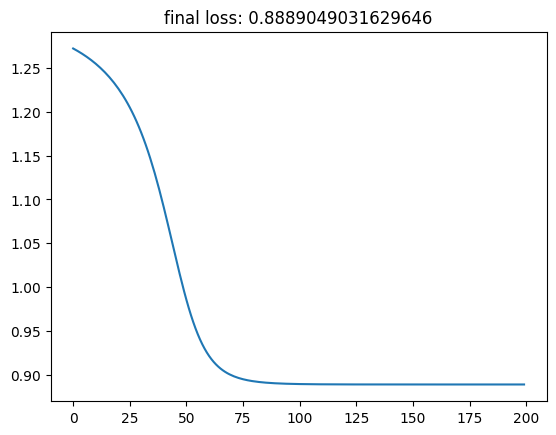

In [14]:
from matplotlib import pyplot as plt

%matplotlib inline

X = df[["X0", "X1"]].values  # 输入值
y = df[["Y"]].values  # 真实 y
nn_model = NeuralNetwork(X, y, lr=0.001)  # 定义模型
loss_list = []  # 存放损失数值变化

# 迭代 200 次
for _ in range(200):
    y_ = nn_model.forward()  # 前向传播
    nn_model.backward()  # 反向传播
    loss = np.square(np.subtract(y, y_)).mean()  # 计算 MSE 损失
    loss_list.append(loss)

plt.plot(loss_list)  # 绘制 loss 曲线变化图
plt.title(f"final loss: {loss}")

In [15]:
# TensorFlow 构建神经网络

In [16]:
import tensorflow as tf

tf.get_logger().setLevel("ERROR")

# 将数组转换为常量张量
X = tf.cast(tf.constant(df[["X0", "X1"]].values), tf.float32)
y = tf.constant(df[["Y"]].values)

X.shape, y.shape

(TensorShape([150, 2]), TensorShape([150, 1]))

In [19]:
class Model(object):
    def __init__(self):
        # 初始化权重全为 1，也可以随机初始化
        # 选择变量张量，因为权重后续会不断迭代更新
        self.W1 = tf.Variable(tf.ones([2, 3]))
        self.W2 = tf.Variable(tf.ones([3, 1]))

    def __call__(self, x):
        hidden_layer = tf.nn.sigmoid(tf.linalg.matmul(x, self.W1))  # 隐含层前向传播
        y_ = tf.nn.sigmoid(tf.linalg.matmul(hidden_layer, self.W2))  # 输出层前向传播
        return y_

In [20]:
model = Model()  # 实例化类
y_ = model(X)  # 测试输入
y_.shape  # 输出

TensorShape([150, 1])

In [21]:
# MSE 损失函数,在 tf.losses 模块


def loss_fn(model, X, y):
    y_ = model(X)  # 前向传播得到预测值
    # 使用 MSE 损失函数，并使用 reduce_mean 计算样本总损失
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y_true=y, y_pred=y_))
    return loss


loss = loss_fn(model, X, y)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.2723011>

In [22]:
# 梯度下降优化迭代
# 手动构造梯度下降迭代过程

EPOCHS = 200  # 迭代 200 次
LEARNING_RATE = 0.1  # 学习率

for epoch in range(EPOCHS):
    # 使用 GradientTape 追踪梯度
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)  # 计算 Loss，包含前向传播过程
    # 使用梯度下降法优化迭代
    # 输出模型需优化参数 W1，W2 自动微分结果
    dW1, dW2 = tape.gradient(loss, [model.W1, model.W2])
    model.W1.assign_sub(LEARNING_RATE * dW1)  # 更新梯度
    model.W2.assign_sub(LEARNING_RATE * dW2)

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]")

Epoch [000/200], Loss: [1.2723]
Epoch [100/200], Loss: [0.9051]
Epoch [200/200], Loss: [0.8889]


In [23]:
# 使用 TensorFlow 优化器
# 使用内置的梯度下降迭代优化器

# 定义 SGD 优化器，设定学习率，
optimizer = tf.optimizers.SGD(learning_rate=0.1)
optimizer


loss_list = []  # 存放每一次 loss
model = Model()  # 实例化类
for epoch in range(EPOCHS):
    # 使用 GradientTape 追踪梯度
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)  # 计算 Loss，包含前向传播过程
        loss_list.append(loss)  # 保存每次迭代 loss

    grads = tape.gradient(loss, [model.W1, model.W2])  # 输出自动微分结果
    optimizer.apply_gradients(zip(grads, [model.W1, model.W2]))  # 使用优化器更新梯度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]")

Epoch [000/200], Loss: [1.2723]
Epoch [100/200], Loss: [0.9051]
Epoch [200/200], Loss: [0.8889]


In [24]:
## 完整 TensorFlow 构建神经网络

In [ ]:
class Model(object):
    def __init__(self):
        self.W1 = tf.Variable(tf.ones([2, 3]))
        self.W2 = tf.Variable(tf.ones([3, 1]))

    def __call__(self, x):
        hidden_layer = tf.nn.sigmoid(tf.linalg.matmul(X, self.W1))
        y_ = tf.nn.sigmoid(tf.linalg.matmul(hidden_layer, self.W2))
        return y_


def loss_fn(model, X, y):
    y_ = model(X)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y_true=y, y_pred=y_))
    return loss


X = tf.cast(tf.constant(df[["X0", "X1"]].values), tf.float32)
y = tf.constant(df[["Y"]].values)

model = Model()
EPOCHS = 200

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)
    grads = tape.gradient(loss, [model.W1, model.W2])
    optimizer = tf.optimizers.SGD(learning_rate=0.1)
    optimizer.apply_gradients(zip(grads, [model.W1, model.W2]))

In [ ]:
# 进行 DIGITS 分类测试

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()  # 读取数据

digits_X = digits.data  # 特征值
digits_y = digits.target  # 标签值

digits_X.shape, digits_y.shape


# 独热编码
digits_y = np.eye(10)[digits_y.reshape(-1)]
digits_y

In [ ]:
# 拆分数据
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    digits_X, digits_y, test_size=0.2, random_state=1
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
import tensorflow as tf


# 模型定义
class Model(object):
    def __init__(self):
        # 随机初始化张量参数
        self.W1 = tf.Variable(tf.random.normal([64, 30]))
        self.b1 = tf.Variable(tf.random.normal([30]))
        self.W2 = tf.Variable(tf.random.normal([30, 10]))
        self.b2 = tf.Variable(tf.random.normal([10]))

    def __call__(self, x):
        # tf.cast 不仅可以转换张量类型，还可以直接将 NumPy 数组转换为相应类型的常量张量
        x = tf.cast(x, tf.float32)  # 转换输入数据类型
        # 线性计算 + RELU 激活
        fc1 = tf.nn.relu(tf.add(tf.matmul(x, self.W1), self.b1))  # 全连接层 1
        fc2 = tf.add(tf.matmul(fc1, self.W2), self.b2)  # 全连接层 2
        return fc2


In [ ]:
# 交叉熵损失函数


def softmax(x):
    # Softmax 实现
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)


np.round(softmax([-1.3, 2.6, -0.9]), 2)

In [ ]:
def loss_fn(model, x, y):
    preds = model(x)
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y)
    )


EPOCHS = 200  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 实例化模型类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]")


def accuracy_fn(logits, labels):
    preds = tf.argmax(logits, axis=1)  # 取值最大的索引，正好对应字符标签
    labels = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))


EPOCHS = 500  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 实例化模型类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度

    accuracy = accuracy_fn(model(X_test), y_test)  # 计算准确度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]"
        )

In [ ]:
#  TensorFlow 实现 Mini Batch 训练

In [ ]:
# 最简单的训练方式，每一次都将全部的数据传入了网络中对参数进行优化，当数据量太大时，矩阵计算就相当夸张了，占用的内存数甚至会导致完全无法训练

# Mini Batch：将整个数据分成一些小批次放进模型里进行训练（K 折交叉验证 是其中一种）

In [ ]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

EPOCHS = 500  # 迭代此时
BATCH_SIZE = 64  # 每次迭代的批量大小
LEARNING_RATE = 0.02  # 学习率

model = Model()  # 实例化模型类

for epoch in tqdm(range(EPOCHS)):  # 设定全数据集迭代次数
    indices = np.arange(len(X_train))  # 生成训练数据长度规则序列
    np.random.shuffle(indices)  # 对索引序列进行打乱，保证为随机数据划分
    batch_num = int(len(X_train) / BATCH_SIZE)  # 根据批量大小求得要划分的 batch 数量
    kf = KFold(n_splits=batch_num)  # 将数据分割成 batch 数量份
    # KFold 划分打乱后的索引序列，然后依据序列序列从数据中抽取 batch 样本
    for _, index in kf.split(indices):
        X_batch = X_train[indices[index]]  # 按打乱后的序列取出数据
        y_batch = y_train[indices[index]]

        with tf.GradientTape() as tape:  # 追踪梯度
            loss = loss_fn(model, X_batch, y_batch)

        trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
        grads = tape.gradient(loss, trainable_variables)  # 计算梯度

        optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
        optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度
        accuracy = accuracy_fn(model(X_test), y_test)  # 计算准确度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]"
        )